In [1]:
import os
from random import shuffle
from tqdm import tqdm
import cv2
import cupy as cp
import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR = os.getcwd() + '\\datasets\\cat_and_dog\\training_set\\training_set'
TEST_DIR = os.getcwd() + '\\datasets\\cat_and_dog\\test_set\\test_set'
TRAIN_DIR, TEST_DIR

('C:\\Users\\Amogh\\Documents\\Study\\MLDL\\datasets\\cat_and_dog\\training_set\\training_set',
 'C:\\Users\\Amogh\\Documents\\Study\\MLDL\\datasets\\cat_and_dog\\test_set\\test_set')

In [3]:
IMAGE_DIM = 64

In [4]:
train_images_cat = [TRAIN_DIR+'\\cats\\'+i for i in os.listdir(TRAIN_DIR+'\\cats')]
train_images_dog = [TRAIN_DIR+'\\dogs\\'+i for i in os.listdir(TRAIN_DIR+'\\dogs')]
test_images_cat = [TEST_DIR+'\\cats\\'+i for i in os.listdir(TEST_DIR+'\\cats')]
test_images_dog = [TEST_DIR+'\\dogs\\'+i for i in os.listdir(TEST_DIR+'\\dogs')]
train_images = train_images_cat[0:150] + train_images_dog[0:50]
shuffle(train_images)
test_images = test_images_cat[0:38] + test_images_dog[0:12]
shuffle(test_images)
len(train_images), len(test_images)

(200, 50)

In [5]:
def find_animal(file_name):
    animal = file_name.split('.')[0].split('\\')[-1]
    if(animal == 'dog'): return 0
    elif(animal == 'cat'): return 1

In [6]:
def create_data(images_list):
    data = []
    for file_name in tqdm(images_list):
        animal = find_animal(file_name)
        resized_image = cv2.resize(cv2.imread(file_name), (IMAGE_DIM, IMAGE_DIM), interpolation=cv2.INTER_AREA)
        data.append([cp.array(resized_image), animal])
    shuffle(data)
    return data

In [7]:
training_data = create_data(train_images)
testing_data = create_data(test_images)

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 312.50it/s]


In [8]:
x_train = cp.stack([i[0] for i in training_data]).reshape(-1, IMAGE_DIM, IMAGE_DIM, 3)
y_train = cp.array([i[1] for i in training_data]).reshape(1,-1)
x_test = cp.stack([i[0] for i in testing_data]).reshape(-1, IMAGE_DIM, IMAGE_DIM, 3)
y_test = cp.array([i[1] for i in testing_data]).reshape(1,-1)

In [9]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((200, 64, 64, 3), (1, 200), (50, 64, 64, 3), (1, 50))

In [10]:
print('m_train = {}'.format(x_train.shape[0]))
print('m_test = {}'.format(x_test.shape[0]))
print('image_dim = {}'.format(x_train.shape[1]))

m_train = 200
m_test = 50
image_dim = 64


In [11]:
x_train_flatten = x_train.reshape(-1, x_train.shape[0])
x_test_flatten = x_test.reshape(-1, x_test.shape[0])

In [12]:
x_train_flatten.shape, y_train.shape, x_test_flatten.shape, y_test.shape

((12288, 200), (1, 200), (12288, 50), (1, 50))

In [13]:
x_train_final = x_train_flatten / 225
x_test_final = x_test_flatten / 225

In [14]:
def sigmoid(z):
    s = 1 / (1 + cp.exp(-z))
    return s

In [15]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


In [16]:
def initialize_with_zeros(dim):
    w = cp.zeros(shape=(dim, 1))
    b = 0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

In [17]:
dim = 5
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
b = 0


In [18]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(cp.dot(w.T, X) + b)
    cost = (-1 / m) * cp.sum(Y * cp.log(A) + (1 - Y) * (cp.log(1 - A)))
    
    dw = (1 / m) * cp.dot(X, (A - Y).T)
    db = (1 / m) * cp.sum(A - Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    
    cost = cp.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw, "db": db}
    
    return grads, cost

In [19]:
w, b, X, Y = cp.array([[1], [2]]), 2, cp.array([[1,2], [3,4]]), cp.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


In [20]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
            
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            
    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    
    return params, grads, costs

In [21]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


In [22]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = cp.zeros((1, m))
    A = sigmoid(cp.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [23]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


In [24]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.005, print_cost=False):
    w, b = initialize_with_zeros(X_train.shape[0])
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    print("Train Accuracy: {} %".format(100 - cp.mean(cp.abs(Y_prediction_train - Y_train)) * 100))
    print("Test Accuracy: {} %".format(100 - cp.mean(cp.abs(Y_prediction_test - Y_test)) * 100))  
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    return d

In [25]:
d = model(x_train_final, y_train, x_test_final, y_test, num_iterations=2000, learning_rate=0.0008, print_cost=True)

Cost after iteration 0: 0.6931471805599452
Cost after iteration 100: 0.5415223689006443
Cost after iteration 200: 0.527357671821337
Cost after iteration 300: 0.5159445558708889
Cost after iteration 400: 0.5062597027630354
Cost after iteration 500: 0.49778745449755024
Cost after iteration 600: 0.4902189130153728
Cost after iteration 700: 0.4833511014551376
Cost after iteration 800: 0.4770426673429428
Cost after iteration 900: 0.4711911722448447
Cost after iteration 1000: 0.4657201385523797
Cost after iteration 1100: 0.4605711007196577
Cost after iteration 1200: 0.4556984684246386
Cost after iteration 1300: 0.4510660768048524
Cost after iteration 1400: 0.4466447993409932
Cost after iteration 1500: 0.4424108556708144
Cost after iteration 1600: 0.43834458768132023
Cost after iteration 1700: 0.4344295589952558
Cost after iteration 1800: 0.4306518824313754
Cost after iteration 1900: 0.4269997110090891
Train Accuracy: 81.5 %
Test Accuracy: 76.0 %


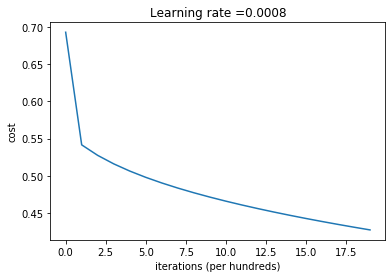

In [26]:
costs = (d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

Learning rate: 0.001
Train Accuracy: 82.0 %
Test Accuracy: 76.0 %
---
Learning rate: 0.0005
Train Accuracy: 78.5 %
Test Accuracy: 76.0 %
---
Learning rate: 0.0001
Train Accuracy: 75.0 %
Test Accuracy: 76.0 %
---


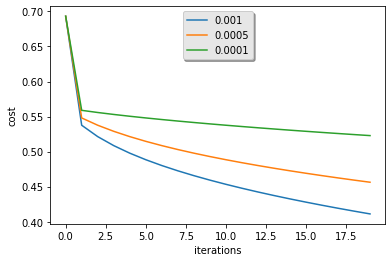

In [27]:
learning_rates = [0.001, 0.0005, 0.0001]
models = {}

for i in learning_rates:
    print("Learning rate: " + str(i))
    models[str(i)] = model(x_train_final, y_train, x_test_final, y_test, num_iterations=2000, learning_rate=i, print_cost=False)
    print("---")
for i in learning_rates:
    plt.plot(models[str(i)]["costs"], label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()